# Clusterização de clientes (BASE_2)

**Objetivo:** Segmentar clientes com base em comportamento e perfil usando clusterização não supervisionada (KMeans). A base tratada contém ~7000 linhas com `importancia_preco` já imputada e uma flag `importancia_preco_imputada` (0/1). A flag será usada apenas para validação de robustez, **não** como feature.

## 1. Seleção de variáveis

Carregamos o Excel e definimos:
- **Numéricas (comportamento):** volume_tipico_compra_ton_mes, frequencia_compra_mensal, importancia_manga_produto_final_1a10
- **Categóricas (perfil):** tipo_cliente, aceita_refugo_como_mp, importancia_preco.
- **Exclusões:** importancia_preco_imputada (flag técnica), IDs e colunas de diagnóstico.

“A variável importancia_certificacoes foi inicialmente considerada, porém análises comparativas mostraram que sua remoção não altera a estrutura dos clusters, mantém o número ótimo de grupos, melhora ligeiramente o silhouette e aumenta a variância explicada no PCA. Dessa forma, optou-se pela versão mais parcimoniosa do modelo, priorizando interpretabilidade sem perda de qualidade.”

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

BASE_DIR = Path('.').resolve()
DATA_PATH = BASE_DIR / 'base_2' / 'BASE_2_Clientes_Manga_tratada_importancia_preco.xlsx'
if not DATA_PATH.exists():
    DATA_PATH = BASE_DIR.parent / 'base_2' / 'BASE_2_Clientes_Manga_tratada_importancia_preco.xlsx'

df = pd.read_excel(DATA_PATH)

num_cols = ['volume_tipico_compra_ton_mes', 'frequencia_compra_mensal', 'importancia_manga_produto_final_1a10']
cat_cols = ['tipo_cliente','aceita_refugo_como_mp', 'importancia_preco']

for c in num_cols + cat_cols:
    if c not in df.columns:
        raise ValueError(f'Coluna ausente: {c}')

X = df[num_cols + cat_cols].copy()
print('Shape X:', X.shape)
print('Colunas:', list(X.columns))

Shape X: (7000, 6)
Colunas: ['volume_tipico_compra_ton_mes', 'frequencia_compra_mensal', 'importancia_manga_produto_final_1a10', 'tipo_cliente', 'aceita_refugo_como_mp', 'importancia_preco']


## 2. Pré-processamento (dados mistos)

Usamos **StandardScaler** nas numéricas (para que distâncias no KMeans não sejam dominadas por variáveis em escalas maiores) e **OneHotEncoder** nas categóricas (sem LabelEncoder nem mapeamento ordinal, para não assumir espaçamento entre categorias).

Assimetria (skew) de volume_tipico_compra_ton_mes: 0.475


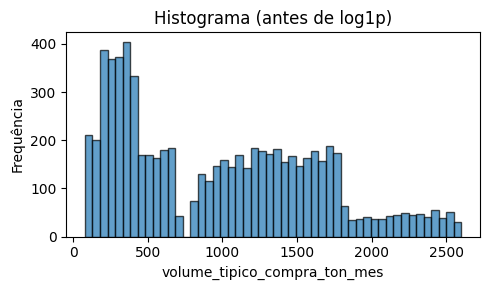

Skew <= 1: mantendo volume original.
Shape após pré-processamento: (7000, 10)


In [65]:
skew_volume = X['volume_tipico_compra_ton_mes'].skew()
print(f'Assimetria (skew) de volume_tipico_compra_ton_mes: {skew_volume:.3f}')

fig_skew, ax_skew = plt.subplots(figsize=(5, 3))
ax_skew.hist(X['volume_tipico_compra_ton_mes'], bins=50, edgecolor='black', alpha=0.7)
ax_skew.set_xlabel('volume_tipico_compra_ton_mes')
ax_skew.set_ylabel('Frequência')
ax_skew.set_title('Histograma (antes de log1p)')
plt.tight_layout()
plt.show()

if skew_volume > 1:
    X['volume_tipico_compra_ton_mes'] = np.log1p(X['volume_tipico_compra_ton_mes'])
    num_cols_use = ['volume_tipico_compra_ton_mes', 'frequencia_compra_mensal', 'importancia_manga_produto_final_1a10']
    print('Skew > 1: usando log1p(volume) na clusterização.')
else:
    num_cols_use = num_cols.copy()
    print('Skew <= 1: mantendo volume original.')

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols_use),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_transformed = preprocess.fit_transform(X)
print('Shape após pré-processamento:', X_transformed.shape)

## 3. Escolha de K (Elbow + Silhouette)

Testamos k de 2 a 8: **inertia** (Elbow) e **silhouette**. Resultados em DataFrame e dois gráficos.

In [66]:
k_range = range(2, 9)
results = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_transformed)
    results.append({'k': k, 'inertia': km.inertia_, 'silhouette': silhouette_score(X_transformed, labels)})

df_k = pd.DataFrame(results)
print(df_k.sort_values('k'))

   k       inertia  silhouette
0  2  22762.728202    0.233388
1  3  18695.474785    0.221300
2  4  15400.163289    0.251677
3  5  14147.427738    0.239048
4  6  13198.198346    0.201893
5  7  12452.441976    0.195758
6  8  11736.491845    0.214966


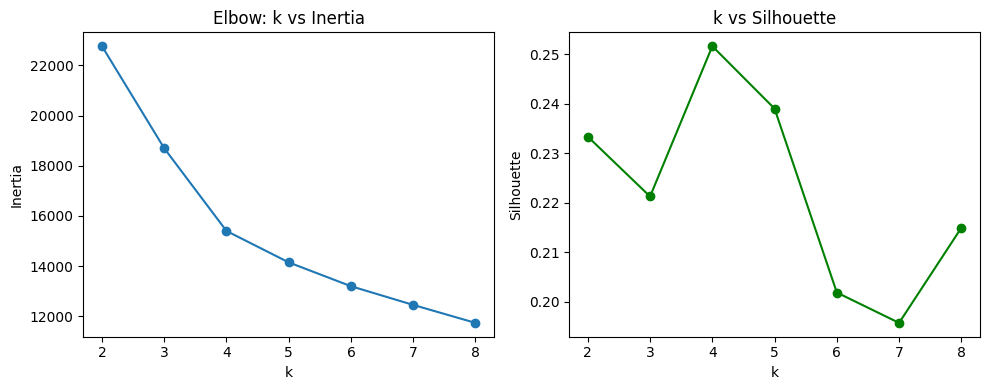

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(df_k['k'], df_k['inertia'], marker='o')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow: k vs Inertia')
ax2.plot(df_k['k'], df_k['silhouette'], marker='o', color='green')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette')
ax2.set_title('k vs Silhouette')
plt.tight_layout()
plt.show()

## 4. Modelo final e clusters

Escolhemos **k_final** pelo joelho do Elbow, silhouette maior e evitando clusters muito pequenos. Treinamos o modelo final e adicionamos o rótulo de cluster ao dataframe.

In [68]:
min_size = 50
candidates = []
for _, row in df_k.iterrows():
    k = int(row['k'])
    km_try = KMeans(n_clusters=k, random_state=42, n_init=20)
    lab = km_try.fit_predict(X_transformed)
    sizes = pd.Series(lab).value_counts()
    ok = sizes.min() >= min_size
    candidates.append({'k': k, 'silhouette': row['silhouette'], 'min_size': sizes.min(), 'ok': ok})
cand_df = pd.DataFrame(candidates)
valid = cand_df[cand_df['ok']]
if len(valid) > 0:
    k_final = int(valid.loc[valid['silhouette'].idxmax(), 'k'])
else:
    k_final = int(df_k.loc[df_k['silhouette'].idxmax(), 'k'])
print(f'k_final escolhido: {k_final} (equilíbrio joelho/silhouette e clusters não muito pequenos)')

model_final = KMeans(n_clusters=k_final, random_state=42, n_init=20)
df['cluster'] = model_final.fit_predict(X_transformed)
print('Tamanhos por cluster:')
print(df['cluster'].value_counts().sort_index())

k_final escolhido: 4 (equilíbrio joelho/silhouette e clusters não muito pequenos)
Tamanhos por cluster:
cluster
0    1725
1    1500
2    2495
3    1280
Name: count, dtype: int64


## 5. Interpretação dos clusters

Tabela-resumo: médias/medianas das numéricas, proporções das categóricas, tamanho e % por cluster. Boxplot de volume, barras de frequência e heatmap de importancia_preco por cluster.

In [69]:
resumo_list = []
for c in sorted(df['cluster'].unique()):
    sub = df[df['cluster'] == c]
    row = {'cluster': c, 'count': len(sub), 'pct': len(sub) / len(df) * 100}
    for col in num_cols:
        if col in sub.columns:
            row[f'{col}_media'] = sub[col].mean()
            row[f'{col}_mediana'] = sub[col].median()
    for col in cat_cols:
        if col in sub.columns:
            for val, pct in (sub[col].value_counts(normalize=True) * 100).items():
                row[f'{col}_{val}'] = pct
    resumo_list.append(row)

resumo = pd.DataFrame(resumo_list)
print('Resumo por cluster (count, pct, numéricas e proporções categóricas):')
pd.set_option('display.max_columns', None)
print(resumo.round(2).to_string())
pd.set_option('display.max_columns', 20)

Resumo por cluster (count, pct, numéricas e proporções categóricas):
   cluster  count    pct  volume_tipico_compra_ton_mes_media  volume_tipico_compra_ton_mes_mediana  frequencia_compra_mensal_media  frequencia_compra_mensal_mediana  importancia_manga_produto_final_1a10_media  importancia_manga_produto_final_1a10_mediana  tipo_cliente_B2B  tipo_cliente_B2C  aceita_refugo_como_mp_Sim  aceita_refugo_como_mp_Não  importancia_preco_Média  importancia_preco_Alta  importancia_preco_Baixa
0        0   1725  24.64                              437.07                                 408.0                            4.25                               4.0                                        6.77                                           7.0             74.26             25.74                      71.77                      28.23                    55.83                   24.29                    19.88
1        1   1500  21.43                              314.45                                 

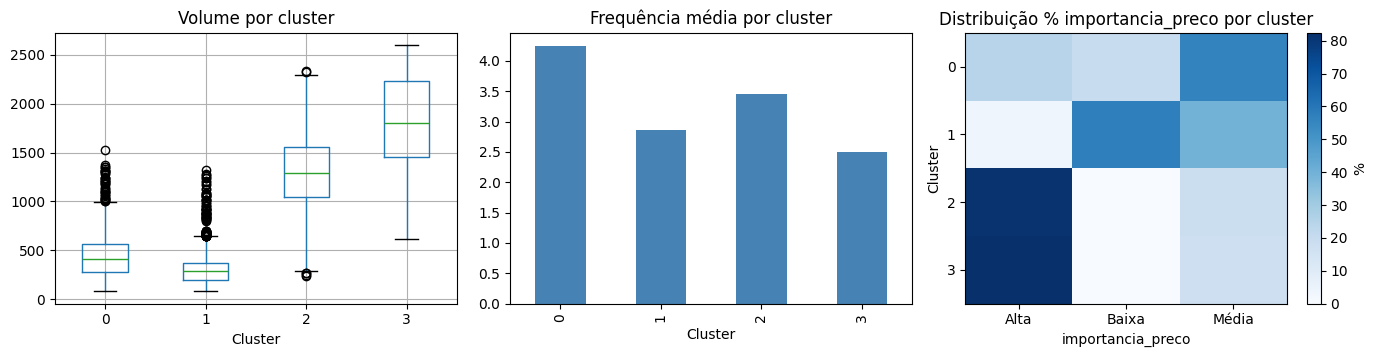

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

df.boxplot(column='volume_tipico_compra_ton_mes', by='cluster', ax=axes[0])
axes[0].set_title('Volume por cluster')
axes[0].set_xlabel('Cluster')

df.groupby('cluster')['frequencia_compra_mensal'].mean().plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('Frequência média por cluster')
axes[1].set_xlabel('Cluster')

pivot = df.pivot_table(index='cluster', columns='importancia_preco', aggfunc='size', fill_value=0)
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
im = axes[2].imshow(pivot_pct.values, aspect='auto', cmap='Blues')
axes[2].set_xticks(range(len(pivot_pct.columns)))
axes[2].set_xticklabels(pivot_pct.columns)
axes[2].set_yticks(range(len(pivot_pct.index)))
axes[2].set_yticklabels(pivot_pct.index)
axes[2].set_xlabel('importancia_preco')
axes[2].set_ylabel('Cluster')
axes[2].set_title('Distribuição % importancia_preco por cluster')
plt.colorbar(im, ax=axes[2], label='%')
plt.tight_layout()
plt.suptitle('')
plt.show()

## 6. Robustez (sem imputados)

Rodamos novamente a clusterização **apenas com linhas onde importancia_preco_imputada == 0**. Mesmo k_final. Comparamos distribuição dos clusters e perfil médio das numéricas para ver se os segmentos se mantêm (boa robustez) ou mudam muito (alerta).

In [71]:
if 'importancia_preco_imputada' not in df.columns:
    print('Coluna importancia_preco_imputada não encontrada; pulando validação.')
else:
    df_sem_imputados = df[df['importancia_preco_imputada'] == 0].copy()
    X_sem = df_sem_imputados[num_cols + cat_cols].copy()
    if skew_volume > 1:
        X_sem['volume_tipico_compra_ton_mes'] = np.log1p(df_sem_imputados['volume_tipico_compra_ton_mes'].values)
    preprocess_sem = ColumnTransformer([
        ('num', StandardScaler(), num_cols_use),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])
    X_sem_transformed = preprocess_sem.fit_transform(X_sem)
    model_sem = KMeans(n_clusters=k_final, random_state=42, n_init=20)
    df_sem_imputados['cluster_sem_imputados'] = model_sem.fit_predict(X_sem_transformed)

    print('=== Tamanhos por cluster (modelo refit SEM imputados) ===')
    print(df_sem_imputados['cluster_sem_imputados'].value_counts().sort_index())
    print('\n=== Perfil médio numérico por cluster (sem imputados) ===')
    print(df_sem_imputados.groupby('cluster_sem_imputados')[num_cols].mean().round(4))
    print('\n=== Comparação: tamanhos no modelo completo ===')
    print(df['cluster'].value_counts().sort_index())
    print('\nSe a distribuição de tamanhos e os perfis médios forem parecidos entre os dois modelos, a robustez é boa. Se mudarem muito, há alerta para dependência dos imputados.')

=== Tamanhos por cluster (modelo refit SEM imputados) ===
cluster_sem_imputados
0    1381
1    2112
2    1808
3    1069
Name: count, dtype: int64

=== Perfil médio numérico por cluster (sem imputados) ===
                       volume_tipico_compra_ton_mes  frequencia_compra_mensal  \
cluster_sem_imputados                                                           
0                                          300.3592                    2.8443   
1                                         1253.6738                    3.4631   
2                                          432.0564                    4.1809   
3                                         1804.6370                    2.5164   

                       importancia_manga_produto_final_1a10  
cluster_sem_imputados                                        
0                                                    8.2085  
1                                                    8.6359  
2                                                    6.7356 

## 7. Conclusão

Resumo: pipeline de clusterização com KMeans + StandardScaler + OneHotEncoder; k escolhido por Elbow e silhouette; interpretação por tabela e gráficos; validação sem imputados para checar robustez.

## Visualização 2D dos clusters (PCA)

Projeção no espaço já pré-processado para ilustração e interpretação (não para escolher o número de clusters).

Variância total explicada pelos 2 componentes: 56.8%


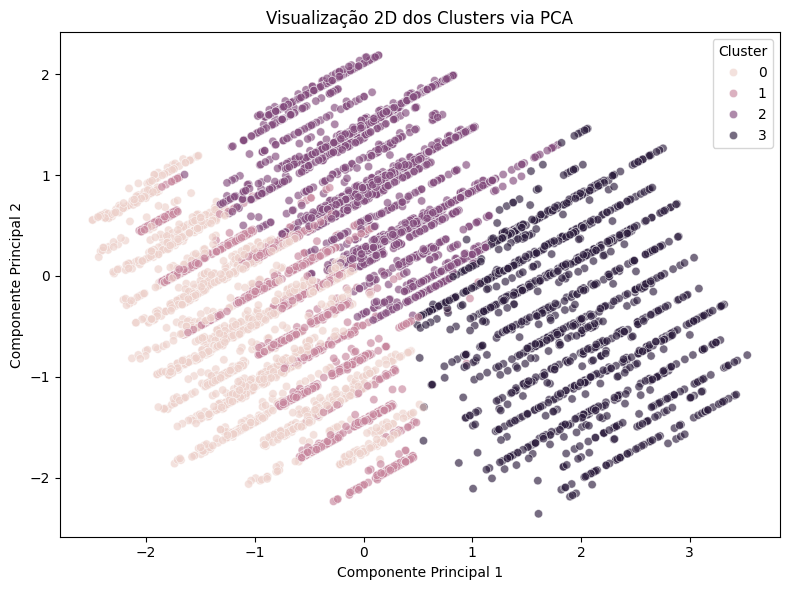

In [72]:
from sklearn.decomposition import PCA
import seaborn as sns

# PCA no espaço já pré-processado (não no dataframe cru)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_transformed)

# DataFrame auxiliar com PC1, PC2, cluster e variância explicada
var_explicada = pca.explained_variance_ratio_
df_pca = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': df['cluster'].values
})

# Variância total explicada pelos dois componentes
var_total_pct = var_explicada.sum() * 100
print(f'Variância total explicada pelos 2 componentes: {var_total_pct:.1f}%')

# Scatter plot 2D
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', alpha=0.65, legend='full')
plt.title('Visualização 2D dos Clusters via PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

## Interpretação e naming dos clusters (para apresentação)

Abaixo: tabelas de suporte (médias/medianas numéricas, proporções categóricas), variáveis que mais diferenciam os clusters e um resumo interpretável por cluster para nomear e usar em slides. O modelo de clusterização **não é alterado**.

In [73]:
# Tabela: médias e medianas das variáveis numéricas por cluster
tab_num = df.groupby('cluster')[num_cols].agg(['mean', 'median']).round(4)
tab_num.columns = [f'{col}_{agg}' for col, agg in tab_num.columns]
tab_num = tab_num.reset_index()
print('Médias e medianas das variáveis numéricas por cluster:')
display(tab_num)

Médias e medianas das variáveis numéricas por cluster:


,cluster,volume_tipico_compra_ton_mes_mean,volume_tipico_compra_ton_mes_median,frequencia_compra_mensal_mean,frequencia_compra_mensal_median,importancia_manga_produto_final_1a10_mean,importancia_manga_produto_final_1a10_median
0,0,437.0655,408.0,4.2487,4.0,6.7733,7.0
1,1,314.4520,286.0,2.8573,3.0,8.1013,8.0
2,2,1287.9190,1293.0,3.4577,3.0,8.5816,9.0
3,3,1831.3641,1806.5,2.5023,3.0,5.9109,6.0


In [74]:
# Tabelas de proporções das variáveis categóricas por cluster
for col in cat_cols:
    prop = df.pivot_table(index='cluster', columns=col, aggfunc='size', fill_value=0)
    prop_pct = prop.div(prop.sum(axis=1), axis=0) * 100
    print(f'Proporções (%) de "{col}" por cluster:')
    display(prop_pct.round(1))

Proporções (%) de "tipo_cliente" por cluster:


tipo_cliente,B2B,B2C
cluster,,
0,74.3,25.7
1,95.9,4.1
2,90.1,9.9
3,99.2,0.8


Proporções (%) de "aceita_refugo_como_mp" por cluster:


aceita_refugo_como_mp,Não,Sim
cluster,,
0,28.2,71.8
1,79.5,20.5
2,12.5,87.5
3,46.1,53.9


Proporções (%) de "importancia_preco" por cluster:


importancia_preco,Alta,Baixa,Média
cluster,,,
0,24.3,19.9,55.8
1,3.6,57.0,39.4
2,81.4,0.2,18.4
3,82.4,0.0,17.6


In [75]:
# Variáveis que mais diferenciam os clusters
# Numéricas: desvio padrão das médias por cluster (maior = mais diferenciação)
medias_por_cluster = df.groupby('cluster')[num_cols].mean()
diff_num = medias_por_cluster.std().sort_values(ascending=False)
print('Diferenciação entre clusters (numéricas) — std das médias por cluster:')
print(diff_num.round(4).to_string())

# Categóricas: qui-quadrado com cluster (maior estatística = mais associação com cluster)
from scipy.stats import chi2_contingency
chi2_list = []
for col in cat_cols:
    tab = pd.crosstab(df['cluster'], df[col])
    chi2, p, _, _ = chi2_contingency(tab)
    chi2_list.append({'variavel': col, 'chi2': chi2, 'p': p})
diff_cat = pd.DataFrame(chi2_list).set_index('variavel').sort_values('chi2', ascending=False)
print('\nDiferenciação entre clusters (categóricas) — qui-quadrado com cluster:')
print(diff_cat.round(4).to_string())
print('\nVariáveis com chi2/p mais altos são as que mais diferenciam os clusters.')

Diferenciação entre clusters (numéricas) — std das médias por cluster:
volume_tipico_compra_ton_mes            720.3614
importancia_manga_produto_final_1a10      1.2226
frequencia_compra_mensal                  0.7643

Diferenciação entre clusters (categóricas) — qui-quadrado com cluster:
                            chi2    p
variavel                             
importancia_preco      4200.8119  0.0
aceita_refugo_como_mp  1908.6759  0.0
tipo_cliente            598.4560  0.0

Variáveis com chi2/p mais altos são as que mais diferenciam os clusters.


In [76]:
# Resumo interpretável por cluster (porte, recorrência, preço, flexibilidade, contexto)
volume_med = df['volume_tipico_compra_ton_mes'].median()
freq_med = df['frequencia_compra_mensal'].median()

resumo_clusters = []
for c in sorted(df['cluster'].unique()):
    sub = df[df['cluster'] == c]
    n, pct = len(sub), len(sub) / len(df) * 100
    vol_med = sub['volume_tipico_compra_ton_mes'].median()
    freq_med_c = sub['frequencia_compra_mensal'].median()
    porte = 'acima da mediana' if vol_med >= volume_med else 'abaixo da mediana'
    recorrencia = 'acima da mediana' if freq_med_c >= freq_med else 'abaixo da mediana'
    # sensibilidade a preço: % Alta naquele cluster
    pct_preco_alta = (sub['importancia_preco'] == 'Alta').mean() * 100
    pct_preco_baixa = (sub['importancia_preco'] == 'Baixa').mean() * 100
    if pct_preco_alta > 40:
        preco = 'sensível (Alta importância)'
    elif pct_preco_baixa > 40:
        preco = 'menos sensível (Baixa importância)'
    else:
        preco = 'intermediário (Média importância)'
    pct_refugo_sim = (sub['aceita_refugo_como_mp'] == 'Sim').mean() * 100
    flex = 'mais flexível (aceita refugo)' if pct_refugo_sim > 50 else 'menos flexível'
    pct_b2b = (sub['tipo_cliente'] == 'B2B').mean() * 100
    contexto = 'predominante B2B' if pct_b2b > 50 else 'predominante B2C'
    resumo_clusters.append({
        'cluster': c, 'n': n, 'pct': round(pct, 1),
        'porte (volume)': porte, 'recorrência': recorrencia,
        'sensibilidade_preco': preco, 'flexibilidade': flex, 'contexto': contexto,
        'vol_med': round(vol_med, 4), 'freq_med': round(freq_med_c, 2),
        'pct_preco_Alta': round(pct_preco_alta, 1), 'pct_refugo_Sim': round(pct_refugo_sim, 1), 'pct_B2B': round(pct_b2b, 1)
    })

df_resumo = pd.DataFrame(resumo_clusters)
print('Resumo interpretável por cluster:')
display(df_resumo[['cluster', 'n', 'pct', 'porte (volume)', 'recorrência', 'sensibilidade_preco', 'flexibilidade', 'contexto']])

Resumo interpretável por cluster:


,cluster,n,pct,porte (volume),recorrência,sensibilidade_preco,flexibilidade,contexto
0,0,1725,24.6,abaixo da mediana,acima da mediana,intermediário (Média importância),mais flexível (aceita refugo),predominante B2B
1,1,1500,21.4,abaixo da mediana,acima da mediana,menos sensível (Baixa importância),menos flexível,predominante B2B
2,2,2495,35.6,acima da mediana,acima da mediana,sensível (Alta importância),mais flexível (aceita refugo),predominante B2B
3,3,1280,18.3,acima da mediana,acima da mediana,sensível (Alta importância),mais flexível (aceita refugo),predominante B2B


In [77]:
# Sugestão de nomes/labels para cada cluster (para slides)
# Baseado em: porte, recorrência, sensibilidade a preço, flexibilidade, contexto B2B/B2C
nomes_sugeridos = {}
for _, row in df_resumo.iterrows():
    c = row['cluster']
    p, r, preco, flex, ctx = row['porte (volume)'], row['recorrência'], row['sensibilidade_preco'], row['flexibilidade'], row['contexto']
    # Monta um label curto interpretável
    partes = []
    if 'acima' in str(p): partes.append('Grande porte')
    else: partes.append('Pequeno/médio porte')
    if 'acima' in str(r): partes.append('recorrente')
    else: partes.append('menos recorrente')
    if 'sensível' in str(preco): partes.append('preço sensível')
    elif 'menos sensível' in str(preco): partes.append('preço menos sensível')
    if 'flexível' in str(flex) and 'mais' in str(flex): partes.append('flexível')
    if 'B2B' in str(ctx): partes.append('B2B')
    else: partes.append('B2C')
    nomes_sugeridos[c] = ' — '.join(partes)

print('Sugestão de nomes para apresentação (cluster → label):')
for c, nome in sorted(nomes_sugeridos.items()):
    print(f'  Cluster {c}: {nome}')

Sugestão de nomes para apresentação (cluster → label):
  Cluster 0: Pequeno/médio porte — recorrente — flexível — B2B
  Cluster 1: Pequeno/médio porte — recorrente — preço sensível — B2B
  Cluster 2: Grande porte — recorrente — preço sensível — flexível — B2B
  Cluster 3: Grande porte — recorrente — preço sensível — flexível — B2B


Use as tabelas acima e o resumo por cluster para definir os nomes finais dos segmentos nos slides. Os nomes sugeridos são apenas uma base; ajuste conforme a narrativa da apresentação.